In [1]:
pip install pyserial

Note: you may need to restart the kernel to use updated packages.


In [1]:
#to reload old data comment out file definition and run this cell to refresh memory
date=f"19Aug2025"
#f"05Aug2025"

file="robot_log_"+date
filename=file+ ".csv"
txtfile=file+ ".txt"

In [2]:
#check for the titles being set to correct data set
print(date)
print(filename)
print(txtfile)

19Aug2025
robot_log_19Aug2025.csv
robot_log_19Aug2025.txt


wrapped offset [tics]
[ 6.  6.  6. ... 10. 10. 10.]
angle per tic [rads]
0.5235987755982988
theta 1 wrapped [rads]
[3.14159265 3.14159265 3.14159265 ... 5.23598776 5.23598776 5.23598776]
theta1 all [rads]
[ 3.14159265  3.14159265  3.14159265 ... 24.08554368 24.08554368
 24.08554368]


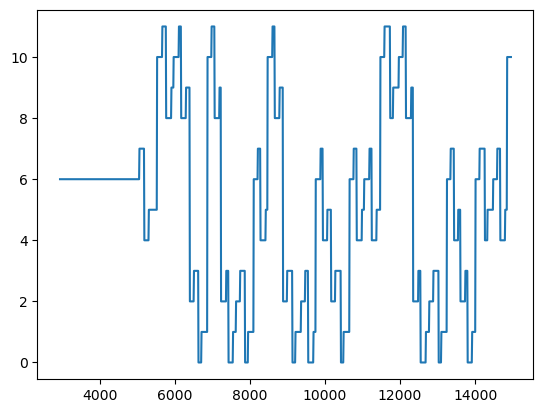

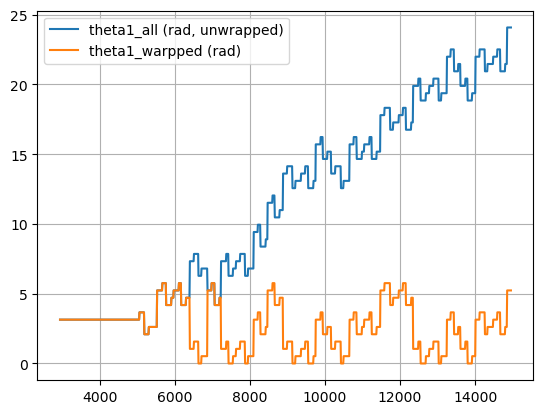

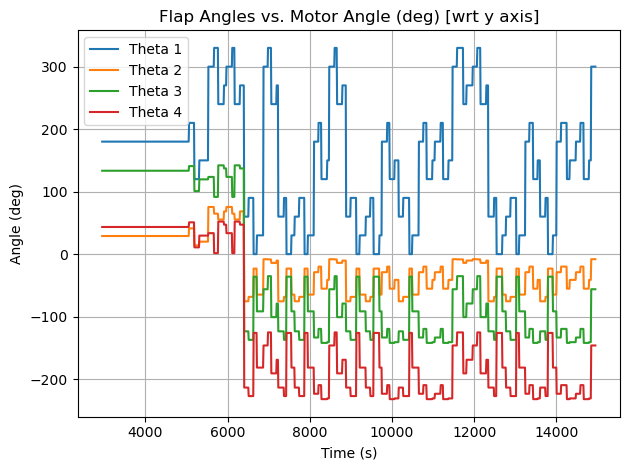

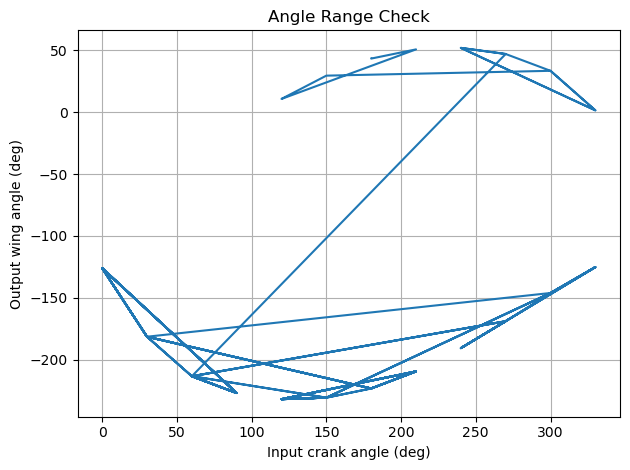

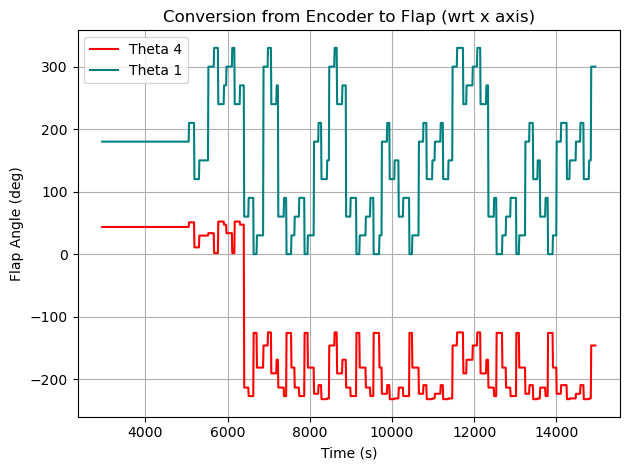

[  43.43253656   43.43253656   43.43253656 ... -146.19850386 -146.19850386
 -146.19850386]
[-43.43253656 -43.43253656 -43.43253656 ... 146.19850386 146.19850386
 146.19850386]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fsolve

# link lengths (mm)
L1 = 5.5  # input
L2 = 11.55  # coupler
L3 = 7.70  # output
L4 = 9.90  # fixed base

# pull data from file and store it
#key:  (time, right crank angle, left crank angle, pwr A, pwr B)
#data = np.loadtxt('robot_log.txt', delimiter='\t', usecols=(0, 1, 2))  # ignore trailing commas (I messed up in my original print function)
data=pd.read_csv(txtfile, delimiter=",", header=None)
#data=pd.read_csv(txtfile, sep=r"\s+", header=None)

# extract each variable column from file KEY:(time, right count, left count, right bound degrees, left bound degrees, pwr right, prw left)
time = data.iloc[:, 0].to_numpy()
right_count= data.iloc[:, 1].to_numpy()
left_count= data.iloc[:, 2].to_numpy()
right_theta_deg = data.iloc[:, 3].to_numpy()
left_theta_deg = data.iloc[:, 4].to_numpy()

#adding unwrapped ticks and offset
tics=right_count
offset=tics+6 #starting offset in ticks
wrapped_offset=np.mod(offset, 12) #find what fraction of a rotation it's at
angle_per_tic=2*np.pi/12

# pick a wing here (sub left for left trial)
encoder_all = 2*np.pi/12*wrapped_offset #for the solver in radians
encoder_all_unwrapped = angle_per_tic*offset

#conversion to properly limited units
#theta1_all = np.unwrap(encoder_all_unwrapped)       # rest of code assumes rads, continuous angle
#theta1_wrapped=np.mod(encoder_all_unwrapped, 2*np.pi)

theta1_wrapped = encoder_all
#(2*np.pi/ 12) * (offset % 12)
theta1_deg_wrap=np.rad2deg(theta1_wrapped)

#unwrapped continuous for plotting
theta1_all = np.unwrap(theta1_wrapped)


print("wrapped offset [tics]")
print(wrapped_offset)
print("angle per tic [rads]")
print(angle_per_tic)
print("theta 1 wrapped [rads]")
print(theta1_wrapped)
print("theta1 all [rads]")
print(theta1_all)

plt.figure()
plt.plot(time, wrapped_offset)
plt.title("Wrapped Offset"

# storage for outputs
theta2_output = []
theta3_output = []
theta4_output= []
theta4_y = []

#guessing a starting value for values of theta 2 and 3 
initial_guess=[np.radians(60), np.radians(30)]

#write key functions from calculations
def sys_equations(unknowns, theta1_wrapped,L1,L2,L3,L4):
    theta2, theta3= unknowns
    equation1=L1*np.cos(theta1_wrapped)+L2*np.cos(theta2)-L3*np.cos(theta3)-L4
    equation2=L1*np.sin(theta1_wrapped)+L2*np.sin(theta2)-L3*np.sin(theta3)
    return[equation1,equation2]

# loop through each input angle and find the unknowns
for t1 in theta1_wrapped:
        #fsolve is (func, x0, args) 
        solution=fsolve(sys_equations, initial_guess, args=(t1,L1,L2,L3,L4))
        theta2, theta3=solution
        #final output flap angle wrt x and y axis
        theta4=np.radians(90)-theta3 
        theta4_yaxis=np.radians(180)-theta3
        theta2_output.append(theta2)
        theta3_output.append(theta3)
        theta4_output.append(theta4)
        theta4_y.append(theta4_yaxis)
        
        #continuously update to test other values
        initial_guess=solution
        
#test value to make sure loading from file
#print("Theta2 (first 5):", theta2_output[:5])

#plot in radians

#plt.figure(1)
#plt.plot(time, theta1_wrapped, label='Theta 1')
#plt.plot(time, theta2_output, label='Theta 2')
#plt.plot(time, theta3_output, label='Theta 3')
#plt.plot(time, theta4_output, label='Theta 4')
#plt.xlabel('Time (s)')
#plt.ylabel('Angle (rad)')
#plt.title('Four-Bar Linkage Output Angles vs. Input Angle(rad)')
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()


#conversion back to original degrees to check graph (has to be after trig)
deg_theta1= theta1_deg_wrap
deg_theta2=np.rad2deg(theta2_output)
deg_theta3=np.rad2deg(theta3_output)
deg_theta4=np.rad2deg(theta4_output)
deg_theta4_y=np.rad2deg(theta4_y)
theta4_adjusted=deg_theta4

plt.figure()
#plt.plot(time, encoder_all, label="encoder_all (rad, wrapped 0–2π)")
plt.plot(time, theta1_all, label="theta1_all (rad, unwrapped)")
plt.plot(time, theta1_wrapped, label="theta1_warpped (rad)")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(2)
plt.plot(time, deg_theta1, label='Theta 1')
plt.plot(time, deg_theta2, label='Theta 2')
plt.plot(time, deg_theta3, label='Theta 3')
plt.plot(time, -deg_theta4, label='Theta 4')
plt.xlabel('Time (s)')
plt.ylabel('Angle (deg)')
plt.title('Flap Angles vs. Motor Angle (deg) [wrt y axis]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# angle range check plot
plt.plot(deg_theta1, -theta4_adjusted)
plt.xlabel('Input crank angle (deg)')
plt.ylabel('Output wing angle (deg)')
plt.title('Angle Range Check')
plt.grid(True)
plt.tight_layout()
plt.show()

#output plot
plt.figure(3)
plt.plot(time, -theta4_adjusted, label='Theta 4', color= 'red')
plt.plot(time, deg_theta1, label='Theta 1', color= 'teal')
plt.xlabel('Time (s)')
plt.ylabel('Flap Angle (deg)')
plt.title('Conversion from Encoder to Flap (wrt x axis)')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

print(-deg_theta4)
print(theta4_adjusted)


#export raw and calculated to csv file (KEY: time in ms, output angle in deg)
df_raw=pd.DataFrame({
    0:time,
    1:right_count,
    2:left_count,
    3:right_theta_deg,
    4:left_theta_deg
})

df = pd.DataFrame({
    0: time,
    1: deg_theta4,
})

df_offset = pd.DataFrame({
    0:time,
    1:right_count,
    2:deg_theta1,
    3:deg_theta4,
})

title1=f"{date}both_raw_encoders.csv"
title2=f"{date}flap_output_left.txtwwww"
title3=f"{date}offset.txt"

# save to CSV without index and header (matlab-fix)
df_raw.to_csv(title1, index=False, header=False)
df.to_csv(title2, index=False, header=False)
df_offset.to_csv(title3)
